# Example - Categorical Data

In [1]:
import geopandas as gpd
import pandas

from geocube.api.core import make_geocube

%matplotlib inline

## Load in soil data

In [2]:
ssurgo_data = gpd.read_file("../../test/test_data/input/soil_data_group.geojson")

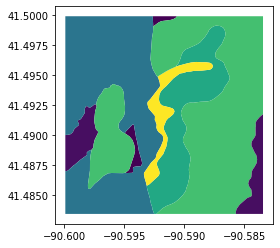

In [3]:
# original data
ssurgo_data[ssurgo_data.hzdept_r==15].plot(column='sandtotal_r')

## Generate categories for categorical data

If your data is only a subset of all of the data, the list of categories you get will likely not be complete.

NOTE: The categories will be made unique and sorted internally if they are not already.

In [4]:
# this is only a subset of all of the classes
ssurgo_data.drclassdcd.drop_duplicates().values.tolist()

['Somewhat poorly drained',
 'Poorly drained',
 'Well drained',
 'Excessively drained']

In [5]:
# complete list of categories
drclasses_complete = [
    'Poorly drained',
    'Somewhat poorly drained',
    'Excessively drained',
    'Subaqueous',
    'Well drained',
    'Somewhat excessively drained',
    'Very poorly drained',
    'Moderately well drained'
]

In [6]:
categorical_enums = {'drclassdcd': drclasses_complete}

## Convert data to grid

See docs for [make_geocube](../geocube.rst#make-geocube)

In [7]:
out_grid = make_geocube(
    vector_data=ssurgo_data,
    output_crs="epsg:32615",
    group_by='hzdept_r',
    resolution=(-100, 100),
    categorical_enums=categorical_enums
)

In [8]:
out_grid

<xarray.Dataset>
Dimensions:                (drclassdcd_categories: 9, hzdept_r: 11, x: 15, y: 19)
Coordinates:
  * y                      (y) float64 4.597e+06 4.597e+06 ... 4.595e+06
  * x                      (x) float64 7.004e+05 7.004e+05 ... 7.018e+05
  * hzdept_r               (hzdept_r) float64 0.0 5.0 15.0 ... 105.0 120.0 150.0
  * drclassdcd_categories  (drclassdcd_categories) object 'Excessively drained' ... 'nodata'
    spatial_ref            int64 0
Data variables:
    drclassdcd             (hzdept_r, y, x) float64 -1.0 -1.0 -1.0 ... 7.0 7.0
    hzdepb_r               (hzdept_r, y, x) float64 nan nan nan ... 180.0 180.0
    claytotal_r            (hzdept_r, y, x) float64 nan nan nan ... 21.0 21.0
    sandtotal_r            (hzdept_r, y, x) float64 nan nan nan ... 10.0 10.0
    silttotal_r            (hzdept_r, y, x) float64 nan nan nan ... 69.0 69.0
Attributes:
    grid_mapping:  spatial_ref

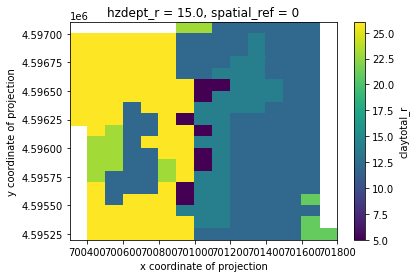

In [9]:
# mask nodata and plot
clay_slice = out_grid.claytotal_r.sel(hzdept_r=15)
clay_slice.where(clay_slice!=out_grid.claytotal_r.rio.nodata).plot()

## Dealing with categorical data

Because the data needs to be numerical for conversion from vector to raster, the code displays the categories as numbers. To convert back to strings, you will need to use the categories provided to convert back.

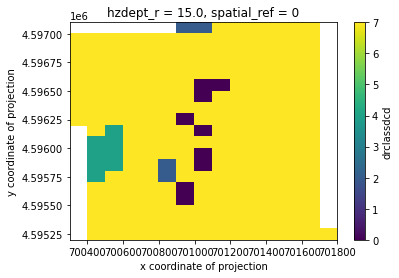

In [10]:
drclassdcd_slice = out_grid.drclassdcd.sel(hzdept_r=15)
drclassdcd_slice.where(drclassdcd_slice!=out_grid.drclassdcd.rio.nodata).plot()

In [11]:
drclassdcd_string = out_grid['drclassdcd_categories'][out_grid['drclassdcd'].astype(int)]\
    .drop('drclassdcd_categories')

In [12]:
out_grid['drclassdcd'] = drclassdcd_string
out_grid

<xarray.Dataset>
Dimensions:                (drclassdcd_categories: 9, hzdept_r: 11, x: 15, y: 19)
Coordinates:
  * y                      (y) float64 4.597e+06 4.597e+06 ... 4.595e+06
  * x                      (x) float64 7.004e+05 7.004e+05 ... 7.018e+05
  * hzdept_r               (hzdept_r) float64 0.0 5.0 15.0 ... 105.0 120.0 150.0
  * drclassdcd_categories  (drclassdcd_categories) object 'Excessively drained' ... 'nodata'
    spatial_ref            int64 0
Data variables:
    drclassdcd             (hzdept_r, y, x) object 'nodata' ... 'Well drained'
    hzdepb_r               (hzdept_r, y, x) float64 nan nan nan ... 180.0 180.0
    claytotal_r            (hzdept_r, y, x) float64 nan nan nan ... 21.0 21.0
    sandtotal_r            (hzdept_r, y, x) float64 nan nan nan ... 10.0 10.0
    silttotal_r            (hzdept_r, y, x) float64 nan nan nan ... 69.0 69.0
Attributes:
    grid_mapping:  spatial_ref

In [13]:
pdf = out_grid.drop(['spatial_ref', 'drclassdcd_categories']).to_dataframe()
pdf.head()

drclassdcd  hzdepb_r  claytotal_r  sandtotal_r  \
hzdept_r x        y                                                             
0.0      700350.0 4597050.0        nodata       NaN          NaN          NaN   
                  4596950.0  Well drained       5.0         26.0         38.0   
                  4596850.0  Well drained       5.0         26.0         38.0   
                  4596750.0  Well drained       5.0         26.0         38.0   
                  4596650.0  Well drained       5.0         26.0         38.0   

                             silttotal_r  
hzdept_r x        y                       
0.0      700350.0 4597050.0          NaN  
                  4596950.0         36.0  
                  4596850.0         36.0  
                  4596750.0         36.0  
                  4596650.0         36.0

### Make sure all categories are represented

To do this, convert the column type to categorical beforehand and make sure that
you include all of the possible categories.

In [14]:
cat_dtype = pandas.api.types.CategoricalDtype(out_grid.drclassdcd_categories.values)
pdf['drclassdcd'] = pdf['drclassdcd'].astype(cat_dtype)

In [15]:
training_df = pandas.get_dummies(pdf, columns=['drclassdcd'])
training_df.head()

hzdepb_r  claytotal_r  sandtotal_r  silttotal_r  \
hzdept_r x        y                                                            
0.0      700350.0 4597050.0       NaN          NaN          NaN          NaN   
                  4596950.0       5.0         26.0         38.0         36.0   
                  4596850.0       5.0         26.0         38.0         36.0   
                  4596750.0       5.0         26.0         38.0         36.0   
                  4596650.0       5.0         26.0         38.0         36.0   

                             drclassdcd_Excessively drained  \
hzdept_r x        y                                           
0.0      700350.0 4597050.0                               0   
                  4596950.0                               0   
                  4596850.0                               0   
                  4596750.0                               0   
                  4596650.0                               0   

                             drclassdcd_Moderately well drained  \
hzdept_r x        y                                               
0.0      700350.0 4597050.0                                   0   
                  4596950.0                                   0   
                  4596850.0                                   0   
                  4596750.0                                   0   
                  4596650.0                                   0   

                             drclassdcd_Poorly drained  \
hzdept_r x        y                                      
0.0      700350.0 4597050.0                          0   
                  4596950.0                          0   
                  4596850.0                          0   
                  4596750.0                          0   
                  4596650.0                          0   

                             drclassdcd_Somewhat excessively drained  \
hzdept_r x        y                                                    
0.0      700350.0 4597050.0                                        0   
                  4596950.0                                        0   
                  4596850.0                                        0   
                  4596750.0                                        0   
                  4596650.0                                        0   

                             drclassdcd_Somewhat poorly drained  \
hzdept_r x        y                                               
0.0      700350.0 4597050.0                                   0   
                  4596950.0                                   0   
                  4596850.0                                   0   
                  4596750.0                                   0   
                  4596650.0                                   0   

                             drclassdcd_Subaqueous  \
hzdept_r x        y                                  
0.0      700350.0 4597050.0                      0   
                  4596950.0                      0   
                  4596850.0                      0   
                  4596750.0                      0   
                  4596650.0                      0   

                             drclassdcd_Very poorly drained  \
hzdept_r x        y                                           
0.0      700350.0 4597050.0                               0   
                  4596950.0                               0   
                  4596850.0                               0   
                  4596750.0                               0   
                  4596650.0                               0   

                             drclassdcd_Well drained  drclassdcd_nodata  
hzdept_r x        y                                                      
0.0      700350.0 4597050.0                        0                  1  
                  4596950.0                        1                  0  
                  4596850.0                        1     

In [16]:
training_df.columns

Index(['hzdepb_r', 'claytotal_r', 'sandtotal_r', 'silttotal_r',
       'drclassdcd_Excessively drained', 'drclassdcd_Moderately well drained',
       'drclassdcd_Poorly drained', 'drclassdcd_Somewhat excessively drained',
       'drclassdcd_Somewhat poorly drained', 'drclassdcd_Subaqueous',
       'drclassdcd_Very poorly drained', 'drclassdcd_Well drained',
       'drclassdcd_nodata'],
      dtype='object')